In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.data_augmentations import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [9]:
EPOCHS = 50
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 120
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
LOSS = kl_divergance_diff
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

stdAugmentation = StdAugmentation(PI_PARAMS)
diffAugmentation = DiffAugmentation()
x_augmentations = [stdAugmentation]
y_augmentations = [stdAugmentation]

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv", 
                           x_augmentations, 
                           y_augmentations,
                           LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

In [10]:
from keras.callbacks.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train The Model

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
callback1 = EarlyStoppingByLossVal(monitor='val_loss', value=0.5, verbose=1)

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.001, loss = LOSS,
                dropout_ratio = 0.5, features_number = FEATURES_NUMBER, callbacks = [], pi_params=PI_PARAMS)

In [14]:
model = M4Model()
model.load( '../models/with_kl_pi_params/3-LSTM/22')
model.compile()
model.train(training_data_generator, test_data_generator, epochs=100)

hist = model.evaluate(validation_data_generator)
print(hist)

Loaded model from disk
Epoch 1/100
129/129 [==============================] - 36s 280ms/step - loss: 0.3469 - val_loss: 0.3657
Epoch 2/100
129/129 [==============================] - 35s 269ms/step - loss: 0.2750 - val_loss: 0.3404
Epoch 3/100
129/129 [==============================] - 35s 268ms/step - loss: 0.2668 - val_loss: 0.3189
Epoch 4/100
129/129 [==============================] - 35s 269ms/step - loss: 0.2603 - val_loss: 0.3281
Epoch 5/100
129/129 [==============================] - 35s 268ms/step - loss: 0.2552 - val_loss: 0.3200
Epoch 6/100
129/129 [==============================] - 35s 270ms/step - loss: 0.2494 - val_loss: 0.3013
Epoch 7/100
129/129 [==============================] - 38s 293ms/step - loss: 0.2422 - val_loss: 0.2872
Epoch 8/100
129/129 [==============================] - 38s 295ms/step - loss: 0.2362 - val_loss: 0.3223
Epoch 9/100
129/129 [==============================] - 37s 288ms/step - loss: 0.2289 - val_loss: 0.2497
Epoch 10/100
129/129 [===================

Epoch 79/100
129/129 [==============================] - 34s 267ms/step - loss: 0.1467 - val_loss: 0.1619
Epoch 80/100
129/129 [==============================] - 34s 266ms/step - loss: 0.1464 - val_loss: 0.1616
Epoch 81/100
129/129 [==============================] - 35s 269ms/step - loss: 0.1464 - val_loss: 0.1651
Epoch 82/100
129/129 [==============================] - 34s 266ms/step - loss: 0.1456 - val_loss: 0.1569
Epoch 83/100
129/129 [==============================] - 34s 266ms/step - loss: 0.1461 - val_loss: 0.1669
Epoch 84/100
129/129 [==============================] - 34s 267ms/step - loss: 0.1457 - val_loss: 0.1640
Epoch 85/100
129/129 [==============================] - 34s 267ms/step - loss: 0.1444 - val_loss: 0.1692
Epoch 86/100
129/129 [==============================] - 34s 266ms/step - loss: 0.1454 - val_loss: 0.1724
Epoch 87/100
129/129 [==============================] - 34s 266ms/step - loss: 0.1445 - val_loss: 0.1555
Epoch 88/100
129/129 [==============================] -

# Save The Model

In [15]:
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params/3-LSTM/23


# Get Best And Worst Predictions

Best Predection Error is     0.1863
Worst Predection Error is    10.3782


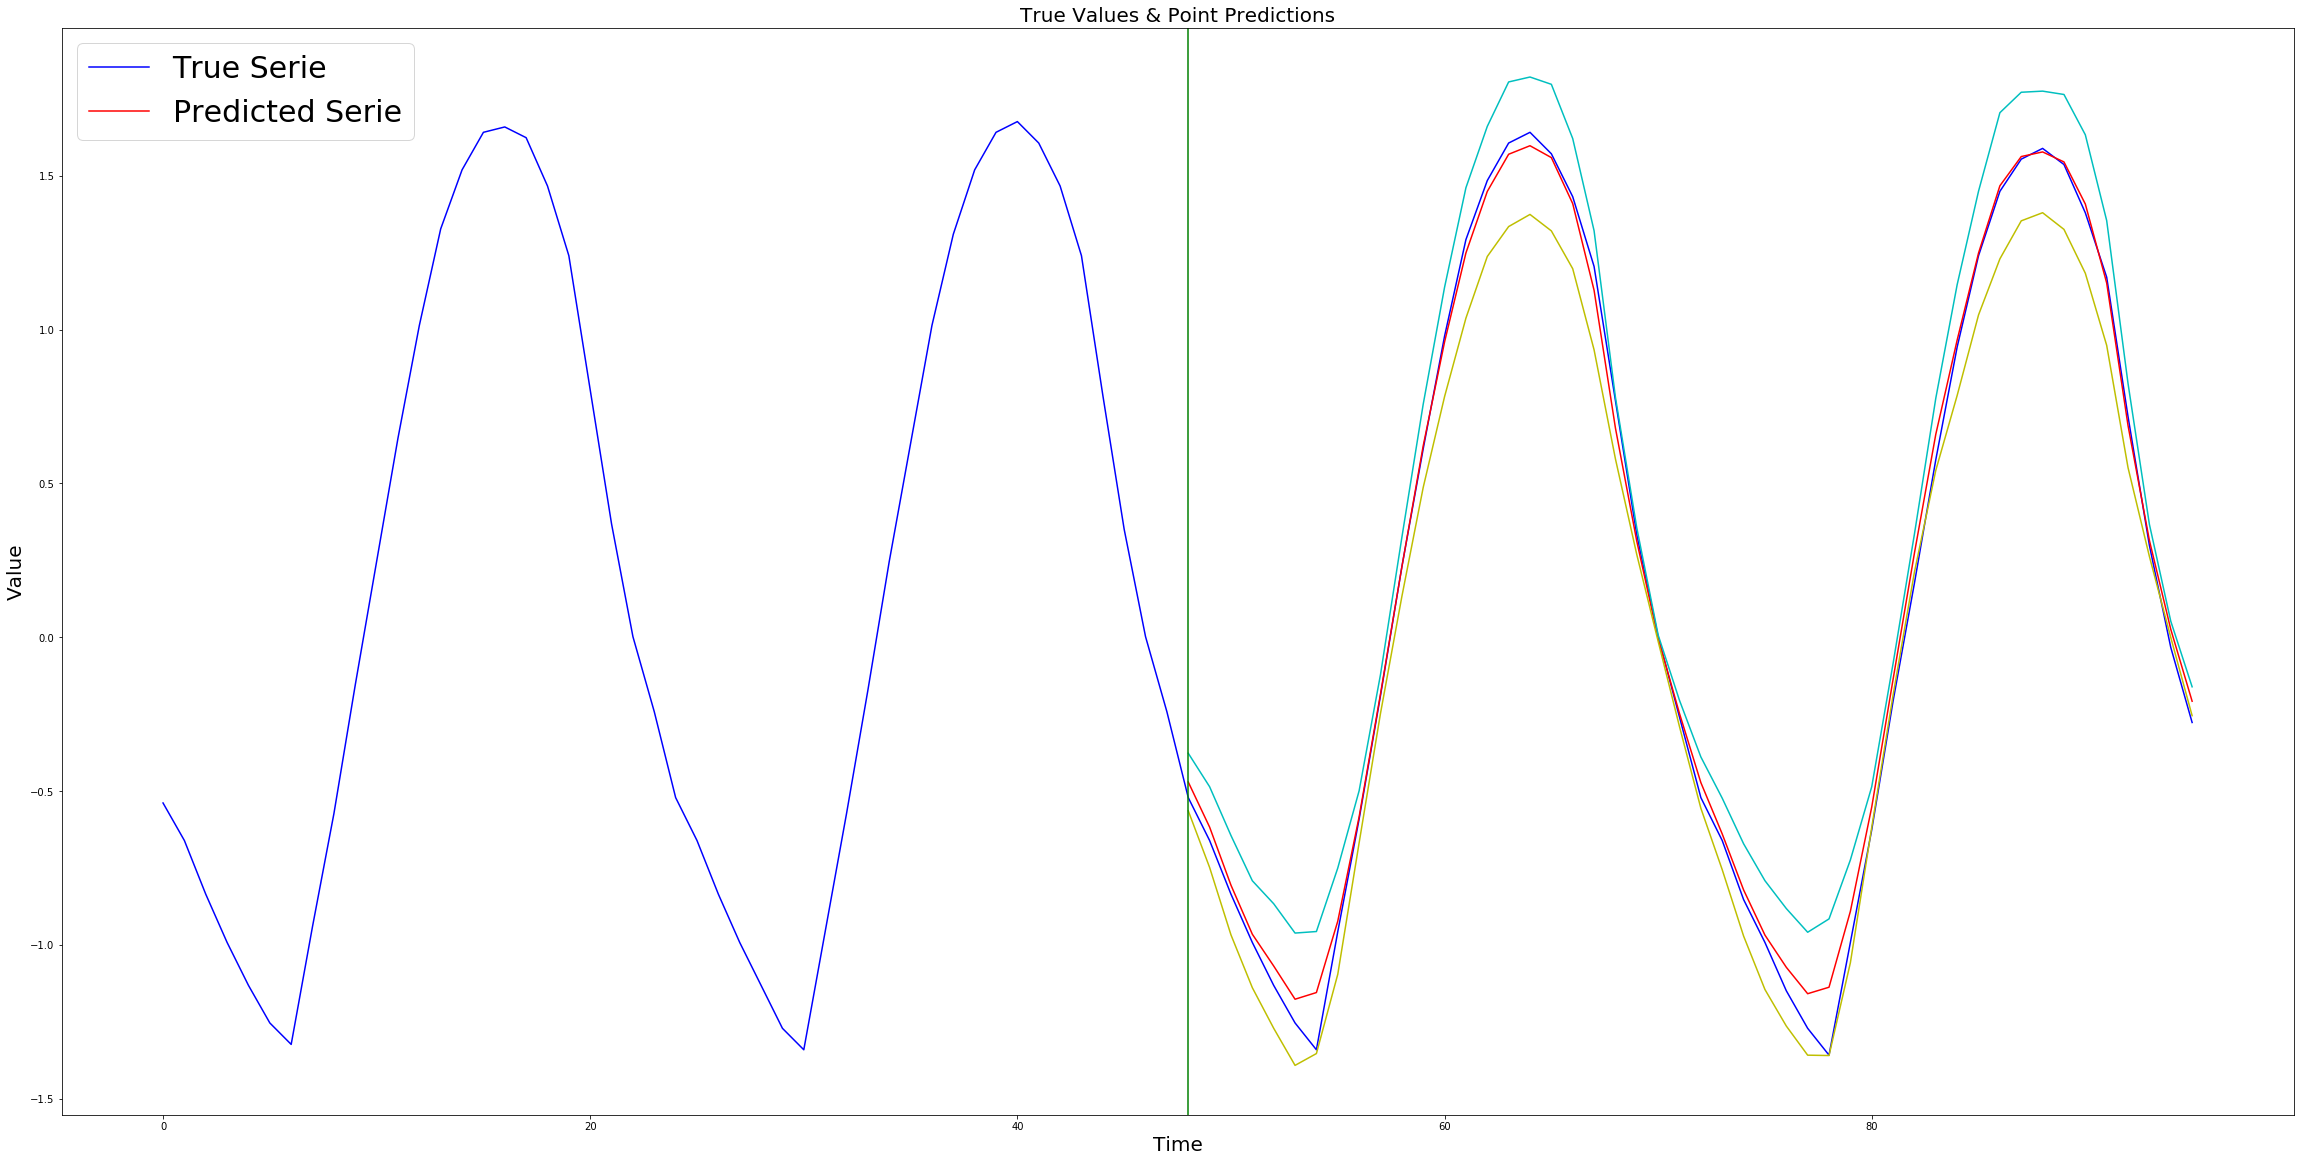

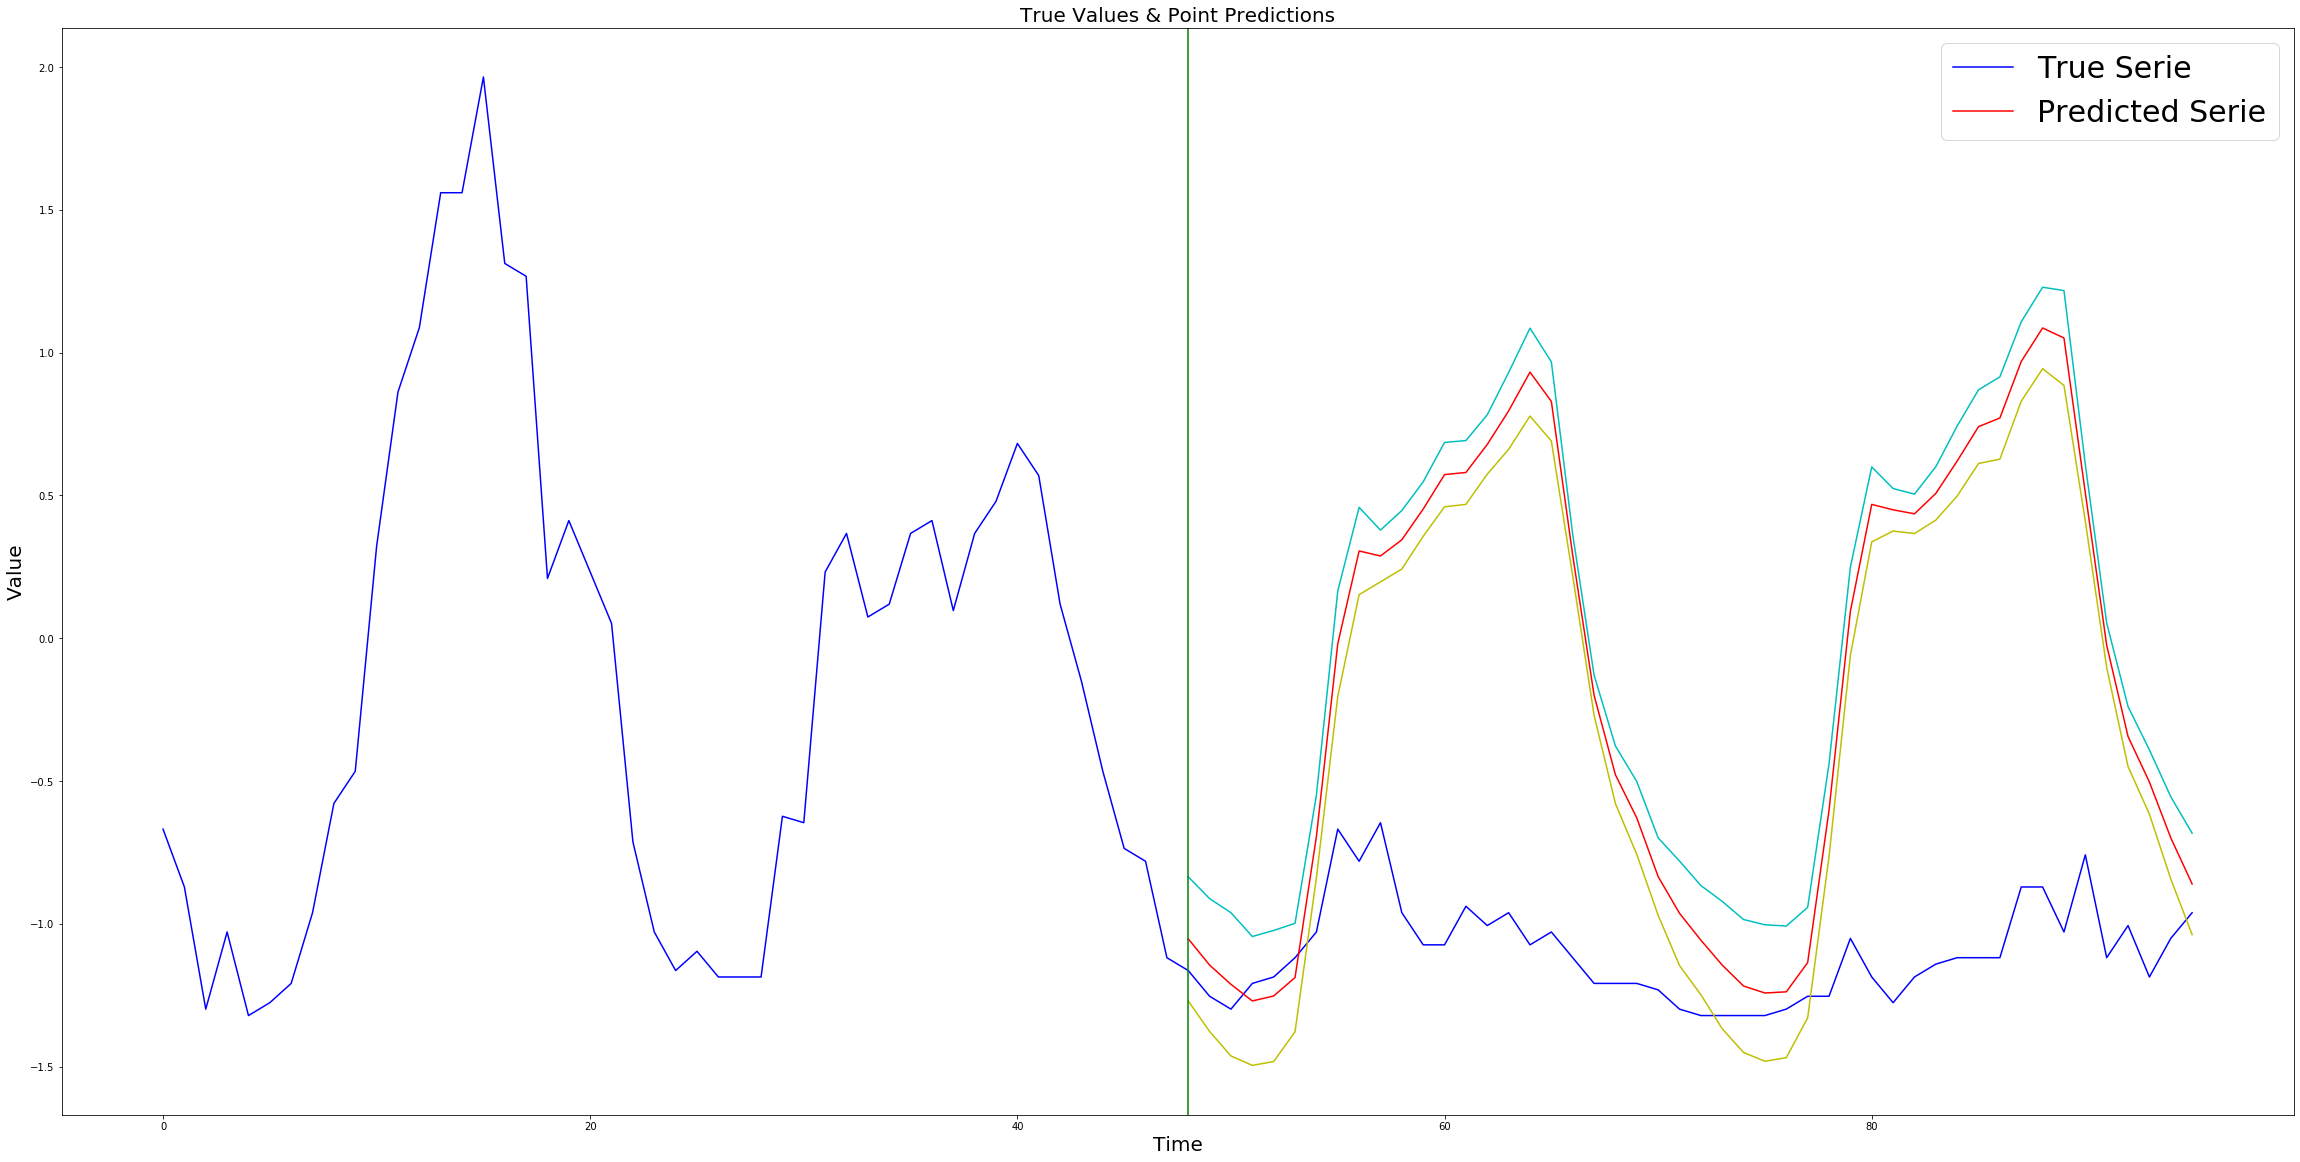

In [16]:
#model = M4Model()
#model.load('../models/with_kl_pi_params/3-LSTM/10')
#print(hp)

x, y, prediction, error =  sort_by_prediction_error(model,test_x, test_y, mase)

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

lower_bound = prediction[:,:48] - tf.abs(prediction[:,-48:])
upper_bound = prediction[:,:48] + tf.abs(prediction[:,-48:])
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=x.shape[0]-1)

# PLot Specific Serie From A Batch

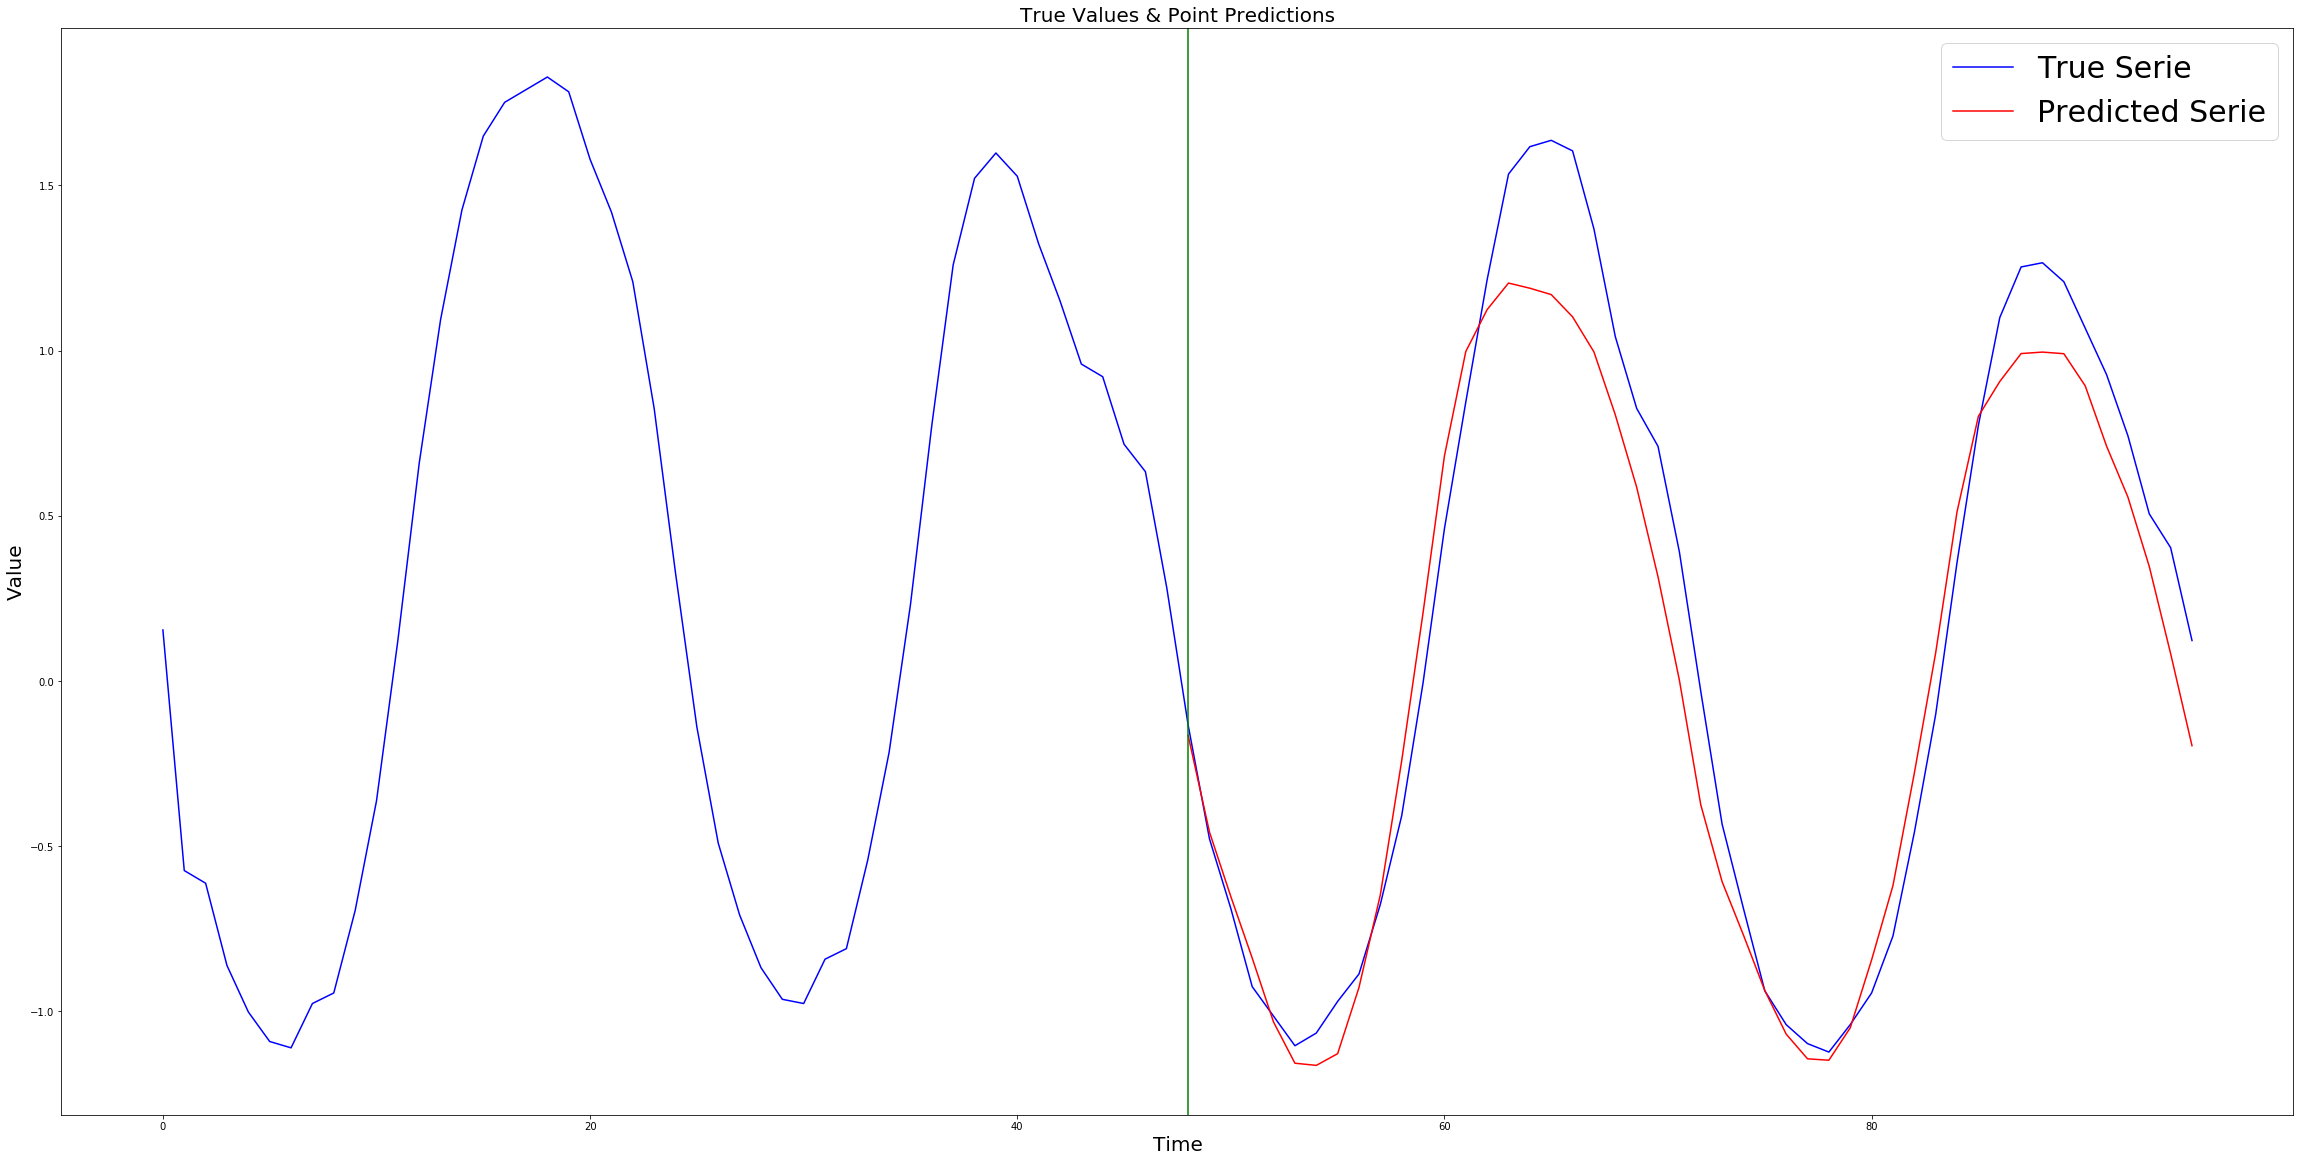

In [8]:
IDX = 0
x = test_x[:BATCH_SIZE,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [8]:
MODEL_NUMBER = 7
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Hyperparameters : {'epochs': 200, 'batch_size': 128, 'hidden_layer_size': 60, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Training Error For Model (7) : 0.906
Test Error For Model (7) : 1.038
Validation Error For Model (7) : 1.073


# Evaluate Model PIs

In [7]:
model = M4Model()
model.load('../models/with_kl_pi_params/3-LSTM/7')

y = test_y[:,:HORIZON]
x = test_x[:,:,0]
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - 2*tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + 2*tf.abs(predictedY[:,-HORIZON:])

print(acd(y, lower_bound.numpy(), upper_bound.numpy()))
print(msis(x, y, lower_bound.numpy(), upper_bound.numpy()))

Loaded model from disk
(394, 48)
0.012510575296108328
9.817209169897252


In [12]:
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
print(acd( y[:,:-1], lower, upper))
print(msis(test_x[:,:,0],  y[:,:-1], lower, upper))

0.0462738956690788
15.255543340076647


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

In [ ]:
lower_bounds = test_y[:,:48] - test_y[:,-48:]
upper_bounds = test_y[:,:48] + test_y[:,-48:]

for y, lower, upper in zip(test_y, lower_bounds, upper_bounds):
    fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    true_series_time_axes = np.arange(0, 48)
    axs.plot(true_series_time_axes, y[:48], color='b')
    axs.plot(true_series_time_axes, lower, color='y')
    axs.plot(true_series_time_axes, upper, color='c')
    plt.show()